In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
tf.random.set_seed(0)
tf.__version__

'2.4.0-rc0'

<h1>Implementation: Neural Probabilistic Language Model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-dataset-from-nltk-data" data-toc-modified-id="Create-dataset-from-nltk-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create dataset from <code>nltk</code> data</a></span></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Embedding-result" data-toc-modified-id="Embedding-result-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Embedding result</a></span></li></ul></div>

## Create dataset from `nltk` data

In [3]:
from nltk.corpus import gutenberg
data = [w.lower() for w in gutenberg.words()]
data[:10]

['[', 'emma', 'by', 'jane', 'austen', '1816', ']', 'volume', 'i', 'chapter']

* build vocabulary

In [5]:
vocab = list(set(data))
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

42339

In [6]:
word_to_ix = {word: ix for ix, word in enumerate(vocab)}

* build custom torchtext dataset with `tf.data.Dataset.from_tensor_slices`.

In [7]:
CONTEXT_SIZE=3

x, y = [], []
for i in range(len(data)-CONTEXT_SIZE):
    x.append(list(map(lambda x: word_to_ix[x], data[i:i+CONTEXT_SIZE])))
    y.append(word_to_ix[data[i+CONTEXT_SIZE]])
x = np.array(x)
y = np.array(y)

In [8]:
x[0], y[0]

(array([27532, 13282, 10722]), 23537)

In [15]:
trainset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(50000).batch(128)

## Build the model

![bengio et al.png](https://miro.medium.com/max/2408/1*EqKiy4-6tuLSoPP_kub33Q.png)

In [11]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 128

In [12]:
class NPLM(tf.keras.Model):
    
    def __init__(self, vocab_size, context_size, embedding_dim, hidden_dim):
        super(NPLM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # affine layers for tanh
        self.flatten = tf.keras.layers.Flatten()
        self.linear1 = tf.keras.layers.Dense(hidden_dim, activation="tanh")
        self.linear2 = tf.keras.layers.Dense(vocab_size, use_bias=False)
        # affine layer for residual connection
        self.linear3 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        
        x1 = self.linear1(x)
        x1 = self.linear2(x1)
        
        x2 = self.linear3(x)
        
        x = x1 + x2
        return x
        

## Train the model

In [13]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

**train with [1-cycle learning rate policy](https://arxiv.org/abs/1708.07120)**

1. write the scheduler

In [17]:
N_EPOCH = 3
MAX_LR = 0.1
MIN_LR = 0.01

def scheduler(epoch, lr):
    step_size = (MAX_LR - MIN_LR) / (N_EPOCH // 2.1)
    half_cycle = N_EPOCH // 2.1
    
    # exploration
    if epoch < half_cycle:
        return lr + step_size
    
    # exploitation
    elif epoch < 2 * half_cycle:
        return lr - step_size
    else:
        return lr * tf.math.exp(-1.)

lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

2. train the model

In [18]:
model = NPLM(VOCAB_SIZE, CONTEXT_SIZE, EMBEDDING_DIM, HIDDEN_DIM)

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=MIN_LR, momentum=0.9)

In [20]:
model.compile(
    optimizer=optimizer,
    loss=criterion,
    metrics=["accuracy"]
)

```python
history = model.fit(trainset, epochs=N_EPOCH, callbacks=[lrscheduler])

plt.plot(history.history["loss"])
```

* save the model

```python
model.save("./NPLM_SGD_lr0.01-0.1_momentum0.9_epoch3")
```

## Embedding result

* load the pre-trained final model

In [ ]:
model = tf.keras.models.load_model("./NPLM_SGD_lr0.01-1.0_momentum0.9_epoch50/")

In [26]:
embedding = model.embedding

In [32]:
from collections import Counter

test_words = Counter(data).most_common(100)
test_words_raw = [w.lower() for w, _ in test_words]
test_words = [word_to_ix[w.lower()] for w in test_words_raw]

In [37]:
from sklearn.manifold import TSNE
embed_xy = embedding(np.array(test_words)).numpy()
embed_xy = TSNE(2).fit_transform(embed_xy)
embed_x, embed_y = list(zip(*embed_xy))

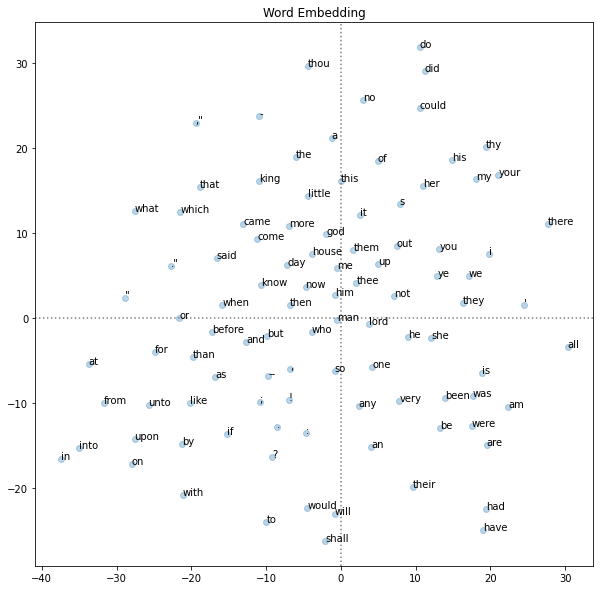

In [38]:
plt.figure(figsize=(10,10))

for xy, word in zip(embed_xy, test_words_raw):
    plt.annotate(word, xy, clip_on=True)

plt.title("Word Embedding")
plt.scatter(embed_x, embed_y, alpha=.3)
plt.axhline([0], ls=":", c="grey")
plt.axvline([0], ls=":", c="grey")

* 5-most similar words

In [1]:
from sklearn.metrics.pairwise import cosine_distances

In [54]:
def find_similar(word, n=5, from_total=5000):
    distance = []
    y = embedding(word_to_ix[word]).numpy().reshape(1, -1)
    total = Counter(data).most_common(from_total)
    for w, _ in total:
        x = embedding(word_to_ix[w]).numpy().reshape(1, -1)
        distance.append(cosine_distances(x, y)[0][0])
    
    distance = np.array(distance)
    top_n = distance.argsort()[1:n+1]
    
    return [total[ix][0] for ix in top_n]

In [55]:
print(f"she  : {find_similar('she')}")
print(f"heart: {find_similar('heart')}")
print(f"love : {find_similar('love')}")
print(f"death: {find_similar('death')}")

she  : ['emma', 'alice', 'anne', 'he', 'elinor']
heart: ['wisdom', 'mouth', 'righteousness', 'tongue', 'flag']
love : ['kingdom', 'honour', 'praise', 'grace', 'serve']
death: ['life', 'hell', 'truth', 'wisdom', 'law']
